this is good shit: https://www.kaggle.com/imdevskp/covid-19-analysis-visualization-comparisons

this is very good shit: https://datelazi.ro/

this is gold: https://www.kaggle.com/gpreda/covid-19-romania-county-level

In [ ]:
!pip install unidecode

In [ ]:
import requests
import os.path as path
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
import json
from unidecode import unidecode
from folium.plugins import HeatMap, HeatMapWithTime
from shapely.geometry import shape, Point, Polygon

Here starts data processing part

In [ ]:

guvid = "guvid.xlsx"
vaccin = "vaccin.xlsx"
populatie ="excel-populatie.xls"

def remove_anthet(fileName):
  wb = openpyxl.load_workbook(fileName)
  for spreadsheetName in wb.sheetnames:
    sheet = wb[spreadsheetName]
    sheet.delete_rows(sheet.min_row, 2)
  wb.save(fileName)

url_stats = 'https://data.gov.ro/dataset/b86a78a3-7f88-4b53-a94f-015082592466/resource/d0b60b45-fb08-4980-a34c-8cbb4a43cad3/download/transparenta_martie_2021.xlsx'
url_vaccinuri = 'https://data.gov.ro/dataset/b86a78a3-7f88-4b53-a94f-015082592466/resource/bc19c354-644d-4a24-a26f-512129dbc70d/download/vaccinare-covid19-grupe-risc-01-25.03.2021.xlsx'
if(not(path.exists(guvid))):  
  r = requests.get(url_stats, allow_redirects=True)
  open(guvid, 'wb').write(r.content)
  remove_anthet(guvid)
else:
  print("guvid exists")

'''

if(not(path.exists(vaccin))):  
  r = requests.get(url_vaccinuri, allow_redirects=True)
  open(vaccin, 'wb').write(r.content)
else:
  print("vaccin exists")

'''

guvid exists


'\n\nif(not(path.exists(vaccin))):  \n  r = requests.get(url_vaccinuri, allow_redirects=True)\n  open(vaccin, \'wb\').write(r.content)\nelse:\n  print("vaccin exists")\n\n'

In [ ]:
# Reading covid transparency dataset
excelDataCovid = pd.ExcelFile(guvid)
dfIncidenta = excelDataCovid.parse('incidenta')
dfTesteJudet = excelDataCovid.parse('teste_judet')
dfTesteRapideJudet = excelDataCovid.parse('teste_rapide_judet')
dfRataPozitivLaborator = excelDataCovid.parse('rata_pozitiv_laborator')
dfTestareLaborator = excelDataCovid.parse('testare_laborator')
dfDurataRecultareRezultat = excelDataCovid.parse('durata_recoltare_rezultat')
dfReinfectareJudet = excelDataCovid.parse('reinfectare_judet')
dfDecedateJudet = excelDataCovid.parse('decedati_judet')
dfPersoaneSpital = excelDataCovid.parse('persoane_spital')
dfPersoaneSpitalAti = excelDataCovid.parse('persoane_spital_ati')
dfPersoanteSpitalAtiJudet = excelDataCovid.parse('persoane_spital_ati_judet')
dfExternatiVindecatiSpital = excelDataCovid.parse('externati_vindecati_spital')
dfExternatiVindecatiJudet = excelDataCovid.parse('externati_vindecati_judet')
dfPopulatie = pd.read_excel(populatie)

In [ ]:
def diacritic_corect(nume):
    newString = ""
    for idx, litera in enumerate(nume):
      if(litera == 'î'):
        if(idx == 0 or( idx > 1 and nume[idx-1] == ' ')):
          newString += nume[idx]
        else:
          newString += 'â'
      else:
          newString += nume[idx]
    return newString

In [ ]:
population_dict = {
    'rimetea' : 1126,
    'saniob' : 2133,
    'sanmihaiudecampie' : 1459,
    'silivasudecampie' : 	872,
    'valenidambovita' : 2754,
    'varfuri' : 1842,
    'barca' : 3689,
    'gangiova' : 2478,
    'radulesti' : 1358,
    'acas' : 2827,
    'barghis' : 2015,
    'albac' : 517,
    'bucuresti': 	1883425
}

judet_dict = {
"AB": "Alba" ,
"AG": "Argeş",
"AR": "Arad",
"B": "Bucureşti",
"BC": "Bacău",	
"BH": "Bihor",
"BN": "Bistriţa-Năsăud",
"BR": "Brăila",
"BT": "Botoşani",
"BV": "Braşov",
"BZ": "Buzău",
"CJ": "Cluj",
"CL": "Călăraşi",
"CS": "Caraş-Severin",
"CT": "Constanţa",
"CV": "Covasna",
"DB": "Dâmboviţa", 	
"DJ": "Dolj",
"GJ": "Gorj",	
"GL": "Galaţi",	
"GR": "Giurgiu",	
"HD": "Hunedoara",
"HR": "Harghita",
"IF": "Ilfov",	
"IL": "Ialomiţa",
"IS": "Iaşi",
"MH": "Mehedinţi",
"MM": "Maramureş"	,
"MS" : "Mureş",
"NT" : "Neamţ",
"OT" : "Olt",
"PH": "Prahova",
"SB": "Sibiu",
"SJ" : "Sălaj",
"SM" : "Satu Mare", 
"SV" :"Suceava" ,
"TL" : "Tulcea", 
"TM" : "Timiş", 
"TR" : "Teleorman",
"VL" : "Vâlcea",
"VN": "Vrancea",
"VS" : "Vaslui" 
}

def name_parse(name):
    if(name in judet_dict):
      name = judet_dict[name]
    new_name = name.lower()
    new_name = diacritic_corect(new_name)
    new_name = new_name.replace("-"," ")
    new_name = new_name.replace(" ","")
    return unidecode(new_name)

def add_population_dict(df):
  for index, row in df.iterrows():
    locality = row['LOCALITATE']
    population = row['POPULATIE']
    population_dict[name_parse(locality)] = population

def convert_columns_to_rows(df):

  if(df.columns[1]=="Judet"):
    static = df.columns[0:2]
  else:
    static = df.columns[0:1]  
  df1 = df.melt(id_vars=static, 
        var_name="data", 
        value_name="value")
  return df1

def get_population_UAT(row):
  return population_dict[name_parse(row['UAT'])]

def get_population_Judet(row):
  return population_dict[name_parse(row['Judet'])]

def parse_value(row):
  if(isinstance(row["value"],str)):
    return 0
  else:
    return row["value"]

def add_uat_population_to_df(df):
  df['Populatie'] = df.apply (lambda row: get_population_UAT(row), axis=1)
  return df

def add_judet_population_to_df(df):
  df['Populatie'] = df.apply (lambda row: get_population_Judet(row), axis=1)
  return df

def parse_uat_df(df):
  df = convert_columns_to_rows(df)
  df = add_uat_population_to_df(df)
  df["value"] = df.apply(lambda row: parse_value(row), axis = 1)
  df.replace('-', np.nan)
  df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
  return df

def parse_judet_df(df):
  df = df[df['Judet'] != 'DIN STRAINATATE']
  df = df[df['Judet'] != 'STS']
  df = convert_columns_to_rows(df)
  df = add_judet_population_to_df(df)
  df["value"] = df.apply(lambda row: parse_value(row), axis = 1)
  df.replace('-', np.nan)
  df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
  return df

In [ ]:
dfsContaintingUat = [
  dfIncidenta                     
]

dfsContainingJudet = [
  dfTesteJudet,
  dfTesteRapideJudet,
  dfDecedateJudet,
  dfPersoaneSpital,
  dfPersoaneSpitalAti,
  dfPersoanteSpitalAtiJudet,
  dfExternatiVindecatiSpital,
  dfExternatiVindecatiJudet
]

add_population_dict(dfPopulatie)

for idx,dfTable in enumerate(dfsContaintingUat):
  new_df  = parse_uat_df(dfTable)
  dfsContaintingUat[idx] = new_df

for idx,dfTable in enumerate(dfsContainingJudet):
  new_df = parse_judet_df(dfTable)
  dfsContainingJudet[idx] = new_df

dfIncidenta = dfsContaintingUat[0]

dfTesteJudet = dfsContainingJudet[0]
dfTesteRapideJudet =dfsContainingJudet[1]
dfDecedateJudet =dfsContainingJudet[2]
dfPersoaneSpital =dfsContainingJudet[3]
dfPersoaneSpitalAti =dfsContainingJudet[4]
dfPersoanteSpitalAtiJudet =dfsContainingJudet[5]
dfExternatiVindecatiSpital =dfsContainingJudet[6]
dfExternatiVindecatiJudet =dfsContainingJudet[7]



Here ends data processing part and starts data visualization part.


In [ ]:
dfIncidenta

,UAT,Judet,data,value,Populatie
0,ALBAC,ALBA,2021-03-01,0.504286,2089
1,ALMAŞU MARE,ALBA,2021-03-01,0.000000,1289
2,ARIEŞENI,ALBA,2021-03-01,0.000000,1765
3,AVRAM IANCU,ALBA,2021-03-01,0.000000,3316
4,BERGHIN,ALBA,2021-03-01,2.608242,1893
...,...,...,...,...,...
98761,SECTOR 2,MUNICIPIUL BUCUREŞTI,2021-03-31,7.279494,345370
98762,SECTOR 3,MUNICIPIUL BUCUREŞTI,2021-03-31,5.914002,385439
98763,SECTOR 4,MUNICIPIUL BUCUREŞTI,2021-03-31,7.080930,287828
98764,SECTOR 5,MUNICIPIUL BUCUREŞTI,2021-03-31,6.377844,271575


In [ ]:
#rata = infectari / pop * 1000
def calc_infect(rate, pop):
  return round(rate * pop / 1000)

def get_infections(df):
  df['infectati'] = df.apply(lambda row: calc_infect(row["value"], row["Populatie"]), axis=1)
  return df

dfIncidentaX = get_infections(dfIncidenta)

In [ ]:
dfIncidentaX

,UAT,Judet,data,value,Populatie,infectati
0,ALBAC,ALBA,2021-03-01,0.504286,2089,1
1,ALMAŞU MARE,ALBA,2021-03-01,0.000000,1289,0
2,ARIEŞENI,ALBA,2021-03-01,0.000000,1765,0
3,AVRAM IANCU,ALBA,2021-03-01,0.000000,3316,0
4,BERGHIN,ALBA,2021-03-01,2.608242,1893,5
...,...,...,...,...,...,...
98761,SECTOR 2,MUNICIPIUL BUCUREŞTI,2021-03-31,7.279494,345370,2514
98762,SECTOR 3,MUNICIPIUL BUCUREŞTI,2021-03-31,5.914002,385439,2279
98763,SECTOR 4,MUNICIPIUL BUCUREŞTI,2021-03-31,7.080930,287828,2038
98764,SECTOR 5,MUNICIPIUL BUCUREŞTI,2021-03-31,6.377844,271575,1732


In [ ]:
def plot_count(feature, value, title, df, size=4):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    df = df.groupby([feature],as_index=False).sum()
    df = df.sort_values([value], ascending=False, na_position="last").reset_index(drop=True)
    df = df.drop(["Populatie"],axis=1)
    g = sns.barplot(df[feature], df[value], palette='Set3')
    g.set_title("Number of {}".format(title))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()  

In [ ]:
def plot_interactive_lines(df, feature, title):
  fig = px.line(df, x="data", y=feature, color='Judet', title=title)
  fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



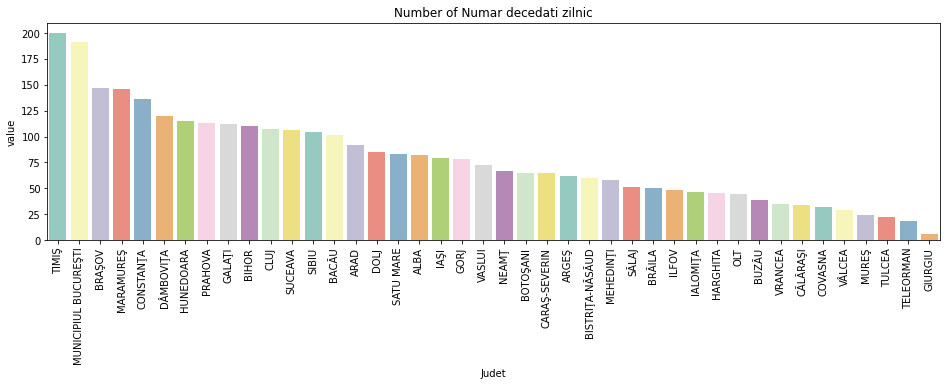

In [ ]:
plot_count("Judet", "value", "Numar decedati zilnic", dfDecedateJudet)

In [ ]:
plot_interactive_lines(dfDecedateJudet, "value", "Numar decedati zilnic")

In [ ]:
ro_geo_data = "romania.geojson"

with open(ro_geo_data) as json_file:
    json_data = json.load(json_file)

dfCoordJud = pd.DataFrame()
for item in json_data['features']:
    polygons = list(shape(item['geometry']))
    judet = item['properties']['name']
    dfCoordJud = dfCoordJud.append(pd.DataFrame({'Judet': judet, 'Lat':polygons[0].centroid.y, 'Long': polygons[0].centroid.x}, index=[0]))

dfCoordJud = dfCoordJud.sort_values(["Judet"])
dfCoordJud.reset_index()
dfDecedateJudetY = dfDecedateJudet.sort_values(["Judet"])
dfDecedateJudetY = dfDecedateJudetY.groupby(["Judet"], as_index=False).sum()


#dfCoordJud.reset_index(inplace=True)
dfCoordJud.reset_index(inplace=True)
#dfCoordJud
dfDecedateJudetY['Lat'] = dfCoordJud['Lat']
dfDecedateJudetY["Long"] = dfCoordJud["Long"]


In [ ]:
ro_map = folium.Map(location=[45.9, 24.9], zoom_start=7)

folium.GeoJson(
    ro_geo_data,
    name="geojson"
).add_to(ro_map)

folium.LayerControl().add_to(ro_map)

In [ ]:
ro_map = folium.Map(location=[45.9, 24.9], zoom_start=6)

dfDecedateJudetYs = dfDecedateJudetY.astype({'value': 'int32'}).dtypes

print(dfDecedateJudetY)

folium.Choropleth(
    geo_data=ro_geo_data,
    name='choropleth',
    data=dfDecedateJudetY,
    columns=['Judet', 'Populatie'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name='Decese / judet'
).add_to(ro_map)

print(dfDecedateJudetY)


ro_map

                   Judet  value  Populatie        Lat       Long
0                   ALBA     82   10613656  46.176678  23.482204
1                   ARAD     92   13349499  46.271831  21.759869
2                  ARGEŞ     62   18985361  45.044968  24.884362
3                  BACĂU    101   19101208  46.421596  26.773866
4                  BIHOR    110   17837338  46.946527  22.204163
5        BISTRIŢA-NĂSĂUD     60    8872975  47.237509  24.520545
6               BOTOŞANI     65   12791406  47.858999  26.760343
7                 BRAŞOV    147   17025727  45.085090  27.676946
8                 BRĂILA     50    9957572  45.764208  25.303869
9                  BUZĂU     39   13983139  44.438901  26.093412
10         CARAŞ-SEVERIN     65    9162949  45.243019  26.745831
11                  CLUJ    107   21424286  44.298970  26.937755
12             CONSTANŢA    136   21206542  45.149020  22.036843
13               COVASNA     32    6515487  46.811655  23.527138
14              CĂLĂRAŞI 

In [ ]:
dfIncidentaWithDates['data'] = pd.to_datetime(dfIncidentaWithDates['data'], format='%Y-%m-%d')


NameError: ignored

In [ ]:

#grafic incidenta (bars), interactiv pe judet / comuna, sortare judete interactiv

In [ ]:
#total teste / judet, interactiv pe zi, combinat PCR + rapide, sortare judete interactiv

In [ ]:
#raport pozitivare / judet, interactiv pe zi, culori diferite in functie de valoare, sortare judete interactiv

In [ ]:
#decese / judet, interactiv pe zi, sortare judete interactiv

In [ ]:
#pers spitalizate / judet, interactiv pe zi (same + ATI)

In [ ]:
#extragere numar maxim de locuri per spital (same + ATI)

In [ ]:
#vindecari / judet sau spital / zi

In [ ]:
#grafic cu toate judetele, evolutia

In [ ]:
#rata mortalitatii

In [ ]:
#grafic cu decese, cazuri active, vindecari combinat

In [ ]:
#treemap judete

In [ ]:
#nr infectari / pop totala